In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
from model_generation import generate_model

C:\Users\Thomas\Anaconda3\envs\tensorflowgpu\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [5]:
model = generate_model()

In [3]:
model3 = generate_model(noise=True)
model4 = generate_model(nums=[0,1],name="keras_mnist_model_zero_onev1.h5")

In [4]:
model5 = generate_model(nums=[0,1,2], name="keras_mnist_model_zero_to_twov1.h5")

In [5]:
model6 = generate_model(nums=[0,1,2,3], name="keras_mnist_model_zero_to_threev1.h5")

In [6]:
model7 = generate_model(nums=[1,7], name="keras_mnist_model_one_sevenv1.h5")

In [5]:
model8 = generate_model(nums=[0,1,7], name="keras_mnist_model_zero_one_sevenv1.h5")

In [3]:
model9 = generate_model(nums=[0,1,2,3,4], name="keras_mnist_model_zero_to_fourv1.h5")

In [5]:
X_train_noise, X_test_noise, Y_train, Y_test = generate_data(noise=True)
score = model.evaluate(X_test_noise, Y_test, verbose=0)
print(score)
score = model3.evaluate(X_test_noise, Y_test, verbose=0)
print(score)

[0.7950517480492592, 0.8241]
[0.7950517480492592, 0.8241]


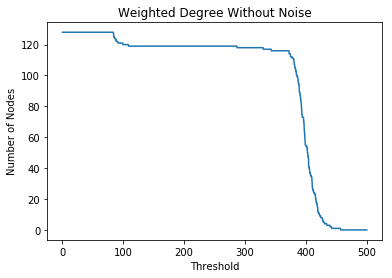

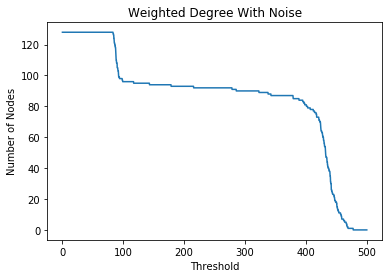

In [4]:
# function counting the number of nodes above a threshold
def thresh_count(arr, thresh):
    return(np.sum(arr > thresh))


def plot_l1_norm(model, title=""):
    # get the dense layer
    dense_layer= model.layers[-3]

    # pull out the weights
    dense_weights = np.array(dense_layer.get_weights())

    # compute the L1 norm for the dense weights
    dense_L1 = np.sum(np.abs(dense_weights[0]), axis = 0)

    # list of thresholds
    thresh_list = np.linspace(0,500, 2000)

    # count the number of nodes for all thresholds
    dense_count = np.array([thresh_count(dense_L1, thresh) for thresh in thresh_list])

    # plot count vs. thresh
    plt.plot(thresh_list, dense_count)
    plt.xlabel("Threshold")
    plt.ylabel("Number of Nodes")
    plt.title(title)
    plt.show()
    
plot_l1_norm(model, title="Weighted Degree Without Noise")
plot_l1_norm(model3, title="Weighted Degree With Noise")

In [10]:
weights = np.abs(np.array(model.layers[-1].get_weights()[0]))
print(weights.shape)
weight_adj_matrix = np.zeros([sum(weights.shape),sum(weights.shape)])
weight_adj_matrix[weights.shape[0]:,:weights.shape[0]] = np.transpose(weights)
print(weight_adj_matrix)

(128, 10)
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.17235444 0.05914584 0.00919179 ... 0.         0.         0.        ]
 [0.39859247 0.14722274 0.36580205 ... 0.         0.         0.        ]
 [0.18943426 0.11194394 0.09362796 ... 0.         0.         0.        ]]


In [9]:
import bct
# bct.betweenness_wei(weight_adj_matrix)

In [56]:
def weighted_clustering_coeff(G):
    """ Calculates clustering coefficient for a weighted network represented by an adjacency matrix """
    # https://www.researchgate.net/publication/49721057_Competition_for_Popularity_in_Bipartite_Networks
    k = G.shape[0] # assume fully connected
    coeffs = np.zeros((k,))
    for i in range(k):
        for j in range(k):
            for h in range(k):
                coeffs[i] += (G[i,j]*G[i,h]*G[h,j])**(1.0/3.0)
        Gv = np.max(G[i,:])
        coeffs[i] *= 2.0/(k*(k-1)*Gv)
    return coeffs

def calc_clustering_coeff_square(weights):
    """ Calculates clustering coefficients for a bipartite weighted network represented by a weight matrix """
    # Compute the unipartite networks correspondign to the bipartite network
    adj1 = np.matmul(weights, np.transpose(weights))
    adj2 = np.matmul(np.transpose(weights), weights)
    return weighted_clustering_coeff(adj1), weighted_clustering_coeff(adj2)

In [57]:
coeffs1, coeffs2 = calc_clustering_coeff_square(weights)

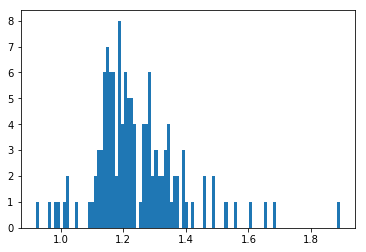

1.2418992631635395


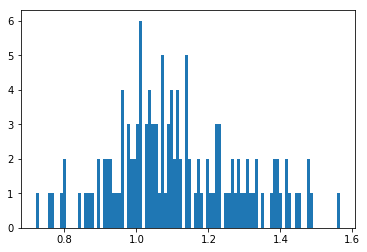

1.1156579708177847


In [59]:
# plt.hist(coeffs1, bins=100, cumulative=True)
plt.hist(coeffs1, bins=100)
plt.show()
print(np.average(coeffs1))

weights_noise = np.abs(np.array(model3.layers[-1].get_weights()[0]))
coeffs1_noise, coeffs2_noise = calc_clustering_coeff_square(weights_noise)
# plt.hist(coeffs1_noise, bins=100, cumulative=True)
plt.hist(coeffs1_noise, bins=100)
plt.show()
print(np.average(coeffs1_noise))

In [54]:
from keras import backend as K

np.random.seed(125)

m = model
# nums = [0,1,2,3,4]
nums = None
# n = len(nums)

weights = np.array(m.layers[-3].get_weights()[0]).transpose()
# weights = np.array(m.layers[-1].get_weights()[0])
# Compute the adjacency matrix of the layer
# layer_adj_matrix = np.matmul(weights, np.transpose(weights))

# Permute the weights randomly to prevent indexing bias
perm = np.random.permutation(weights.shape[0])
# perm = [x for x in range(weights.shape[0])]
weights = weights[perm]

weights_norm = np.linalg.norm(weights[:,:], axis=1)
# print(weights_norm)
print(np.diag(np.reciprocal(weights_norm)).shape)
# Normalize weights
weights_normed = np.matmul(np.diag(np.reciprocal(weights_norm)), weights)
layer_adj_matrix = np.matmul(weights_normed[:,:], np.transpose(weights_normed[:,:]))

# # Compute a layer adjacency matrix composed of 2 nodes repeated 64 times
# print(weights.shape)
# weights_fake = np.concatenate([weights_normed[:16,:]]*8)
# print(weights_fake.shape)
# layer_adj_matrix = np.matmul(weights_fake, np.transpose(weights_fake))

(128, 128)


In [55]:
# Find the highest activation image for each node in the first dense layer
from model_generation import generate_data
X_train, X_test, Y_train, Y_test = generate_data(nums=nums)

inp = m.input                                           # input placeholder
outputs = [m.layers[-3].output, m.layers[-1].output]          # all layer outputs
functor = K.function([inp]+ [K.learning_phase()], outputs ) # evaluation function

# Testing
test = X_test[:5000]
# test = X_test_zero_one[:]
layer_outs = functor([test, 1.])
# layer_outs_2 = functor([X_test[5000:10000], 1.])
# layer_outs = [np.append(layer_outs[0], layer_outs_2[0], axis=0)]
print(layer_outs[0].shape)

(5000, 128)


In [56]:
# Determine index of maximum activation image
max_vals = np.max(layer_outs[0],axis=0)[perm]
# print(max_vals)
repr_indices = np.argmax(np.abs(layer_outs[0]), axis=0)[perm]
# print(np.argmax(layer_outs[0],axis=1))
print(layer_adj_matrix[max_vals!=0][:,max_vals!=0].shape)

(120, 120)


In [57]:
# Create label with mode of top 9 activations
from scipy import stats
top9 = np.argsort(np.abs(layer_outs[0]), axis=0)[-9:,:]
labels = np.argmax(Y_test,axis=1)[repr_indices[max_vals!=0]]
labels_top9 = stats.mode(np.argmax(Y_test,axis=1)[top9])[0][0][perm]
labels_orig = np.argmax(Y_test,axis=1)[repr_indices]
# If the mode count is too low, favor the original labels
low_mode = stats.mode(np.argmax(Y_test,axis=1)[top9])[1][0][perm]<5
labels_top9[low_mode] = labels_orig[low_mode]
labels_top9 = labels_top9[max_vals!=0]

In [49]:
# print(layer_outs[1].shape)
print(np.min(weights))
print(np.min(layer_outs[0]))
print(np.sum(weights[:,:2], axis=0))
best_partners = np.argmax(layer_adj_matrix-np.eye(layer_adj_matrix.shape[0]),axis=0)
labels = np.argmax(Y_test,axis=1)[repr_indices]
# print(labels)
# print(best_partners)
# for i in range(len(best_partners)):
#     print(labels[i]-labels[best_partners[i]])

-0.6088943
0.0
[0.85106444 1.7453755 ]


In [58]:
layer_adj_matrix = layer_adj_matrix[max_vals!=0][:,max_vals!=0]
print(np.max(layer_adj_matrix - layer_adj_matrix.transpose()))

0.0


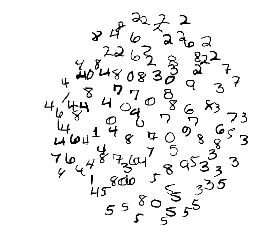

In [59]:
import networkx as nx
from networkx.drawing import spring_layout, spectral_layout, kamada_kawai_layout

# thresh = np.percentile(np.abs(layer_adj_matrix), 10)
# layer_adj_matrix[np.abs(layer_adj_matrix)<thresh] = 0.0

inv_adj_matrix = np.reciprocal(layer_adj_matrix)
# Truncate high values
thresh = np.percentile(inv_adj_matrix, 30)
inv_adj_matrix[inv_adj_matrix>thresh] = 0.0
inv_adj_matrix[inv_adj_matrix<0] = 0.0


# G = nx.Graph(layer_adj_matrix)
# G = nx.Graph(inv_adj_matrix, width=inv_adj_matrix)

# Remove disconnected nodes
# max_vals2 = np.max(inv_adj_matrix, axis=0)
# inv_adj_matrix = inv_adj_matrix[max_vals2!=0][:,max_vals2!=0]

exp_adj_matrix = np.exp(-layer_adj_matrix)
thresh = np.percentile(exp_adj_matrix, 30)
exp_adj_matrix[exp_adj_matrix>thresh] = 0.0

G = nx.Graph(exp_adj_matrix)
# nx.drawing.nx_pylab.draw_spring(G, node_size=40, weight='weight')
layout = kamada_kawai_layout(G, weight='weight')

fig = plt.Figure()
# Generate the image
n = len(layout)
# for i in range(n):
#     for j in range(n):
#         if inv_adj_matrix[i,j]<0.6:
#             pos1 = layout[i]*200
#             pos2 = layout[j]*200
#             plt.plot([pos1[0], pos2[0]], [pos1[1], pos2[1]], alpha=0.05, color="black")
        
for i in range(n):
    pos = layout[i]*200
    extent = [pos[0]-14, pos[0]+14, pos[1]-14, pos[1]+14]
#     img = X_test[repr_indices[i]][0].copy()
    img = X_test[repr_indices[max_vals!=0][i]][0].copy()
#     img = X_test_zero_one[repr_indices[max_vals!=0][i]][0].copy()
#     # add a black border
#     for i in range(len(img)):
#         img[i][0] = 1
#         img[i][-1] = 1
#         for j in range(len(img[0])):
#             img[0][j] = 1
#             img[-1][j] = 1
    img = np.ma.masked_where(img == 0, img)
    plt.imshow(img, interpolation="nearest", extent=extent, cmap="binary")
plt.autoscale()
plt.axis("off")
plt.show()

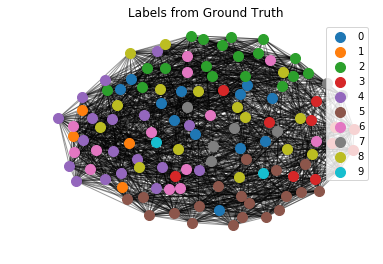

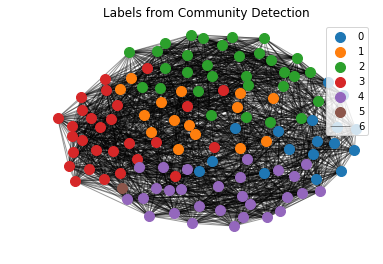

In [68]:
import networkx as nx
from networkx.drawing import spring_layout, spectral_layout, kamada_kawai_layout
from functools import reduce

# thresh = np.percentile(np.abs(layer_adj_matrix), 10)
# layer_adj_matrix[np.abs(layer_adj_matrix)<thresh] = 0.0

inv_adj_matrix = np.reciprocal(layer_adj_matrix)
# Truncate high values
thresh = np.percentile(inv_adj_matrix, 90)
inv_adj_matrix[inv_adj_matrix>thresh] = 0.0
inv_adj_matrix[inv_adj_matrix<0] = 0.0

# layer_adj_matrix2 = layer_adj_matrix.copy()
# layer_adj_matrix2[layer_adj_matrix2<0] = 0.0
# thresh = np.percentile(layer_adj_matrix2, 50)
# layer_adj_matrix2[layer_adj_matrix2>thresh] = 0.0

exp_adj_matrix = np.exp(-layer_adj_matrix)
thresh = np.percentile(exp_adj_matrix, 30)
exp_adj_matrix[exp_adj_matrix>thresh] = 0.0


# G = nx.Graph(inv_adj_matrix)
G = nx.Graph(exp_adj_matrix)
# G = nx.Graph(layer_adj_matrix2)
# nx.drawing.nx_pylab.draw_spring(G, node_size=40, weight='weight')
layout = kamada_kawai_layout(G, weight='weight')

plt.figure()
# Plot each digit as a different color
labels = np.argmax(Y_test,axis=1)[repr_indices[max_vals!=0]]
for i in range(max(nums if nums else [9])+1):
    digit_set = [x[0] for x in np.argwhere(labels_top9==i)]
    # nodes
    nx.draw_networkx_nodes(G,layout,
                           nodelist=digit_set,
                           node_color='C{}'.format(i),
                           node_size=100)

# edges
nx.draw_networkx_edges(G,layout,width=1.0,alpha=0.4)
plt.legend(list(map(str,nums if nums else range(10))))
plt.axis('off')
plt.title('Labels from Ground Truth')
plt.savefig('ground_truth_labels.png')
plt.show()
plt.figure()
# Plot each digit as a different color
labels = np.argmax(Y_test,axis=1)[repr_indices[max_vals!=0]]
# for i in range(max(nums if nums else [9])+1):
#     digit_set = [x[0] for x in np.argwhere(labels_top9==i)]
#     # nodes
#     nx.draw_networkx_nodes(G,layout,
#                            nodelist=digit_set,
#                            node_color='C{}'.format(i),
#                            node_size=100)

for y in set(part.values()):
    nx.draw_networkx_nodes(G,layout,
                           nodelist=[x for x in part if part[x]==y],
                           node_color='C{}'.format(y),
                           node_size=100)

# edges
nx.draw_networkx_edges(G,layout,width=1.0,alpha=0.4)
plt.legend(list(map(str,nums if nums else range(10))))
plt.axis('off')
plt.title('Labels from Community Detection')
plt.savefig('modularity_labels.png')
plt.show()

In [13]:
from networkx.algorithms.community import girvan_newman
from networkx import edge_betweenness_centrality
def weighted_centrality(G):
    return max(edge_betweenness_centrality(G, weight='weight').items(), key=lambda x:x[1])[0]
communities = girvan_newman(G, weighted_centrality)

In [90]:
communities = girvan_newman(G)

In [169]:
from networkx.algorithms.community import asyn_lpa_communities
communities = asyn_lpa_communities(G, weight='weight')
# for x in communities:
# #     print(x)
#     print([labels_top9[i] for i in x])

In [81]:
ebc = edge_betweenness_centrality(G, weight='weight')
# print(ebc)
print(max(ebc.items(), key=lambda x:x[1]))

((10, 62), 0.17817974647486112)


In [15]:
for x in communities:
    print(x)
    for community in x:
        print([labels[i] for i in community])
#     print([labels[i] for i in x])

In [61]:
import community

# part_initial = {x:labels[x] for x in range(len(G.nodes()))}
# print(part_initial)
# part = community.best_partition(G, partition=part_initial, weight='weight')
part = community.best_partition(G, weight='weight', resolution=0.8)
mod = community.modularity(part,G)

print(part)
print(mod)
for y in set(part.values()):
    print([labels[x] for x in part if part[x]==y])

{0: 0, 1: 1, 2: 2, 3: 3, 4: 3, 5: 1, 6: 4, 7: 2, 8: 0, 9: 2, 10: 3, 11: 2, 12: 3, 13: 3, 14: 1, 15: 2, 16: 0, 17: 1, 18: 4, 19: 1, 20: 4, 21: 2, 22: 4, 23: 4, 24: 3, 25: 0, 26: 2, 27: 2, 28: 3, 29: 2, 30: 2, 31: 4, 32: 3, 33: 3, 34: 4, 35: 2, 36: 3, 37: 2, 38: 2, 39: 1, 40: 3, 41: 4, 42: 2, 43: 4, 44: 2, 45: 0, 46: 2, 47: 0, 48: 0, 49: 1, 50: 3, 51: 3, 52: 4, 53: 4, 54: 1, 55: 4, 56: 1, 57: 3, 58: 2, 59: 3, 60: 2, 61: 3, 62: 0, 63: 4, 64: 3, 65: 4, 66: 4, 67: 4, 68: 4, 69: 1, 70: 3, 71: 3, 72: 0, 73: 2, 74: 1, 75: 0, 76: 5, 77: 2, 78: 2, 79: 3, 80: 1, 81: 2, 82: 4, 83: 2, 84: 3, 85: 4, 86: 3, 87: 1, 88: 3, 89: 2, 90: 1, 91: 4, 92: 4, 93: 3, 94: 2, 95: 2, 96: 0, 97: 4, 98: 0, 99: 0, 100: 4, 101: 4, 102: 2, 103: 1, 104: 3, 105: 2, 106: 4, 107: 2, 108: 4, 109: 3, 110: 2, 111: 4, 112: 2, 113: 0, 114: 3, 115: 3, 116: 4, 117: 0, 118: 0, 119: 0}
0.2764108035197496
[7, 3, 9, 3, 7, 8, 3, 6, 8, 4, 7, 7, 7, 3, 7, 3, 5]
[8, 4, 4, 9, 0, 0, 8, 7, 0, 0, 8, 0, 0, 0, 9]
[3, 2, 6, 2, 8, 2, 4, 2, 2, 6, 2

1
1456
1
1665
1664
1663
1662
1661
1660
1667
4999
3673
4


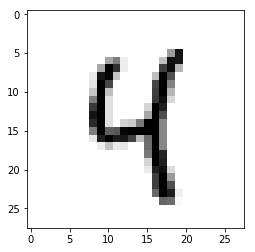

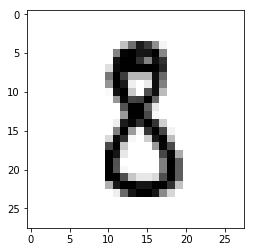

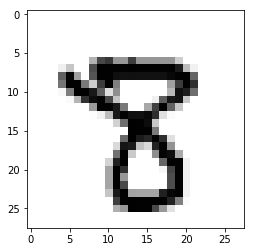

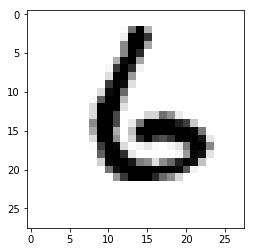

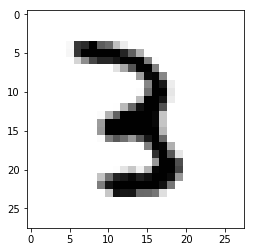

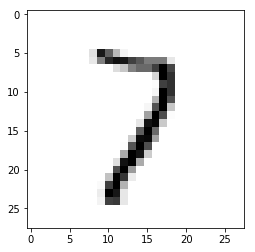

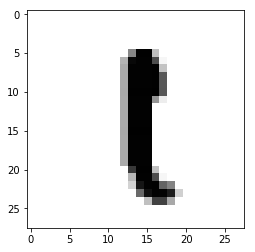

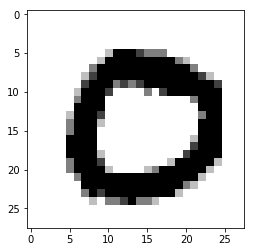

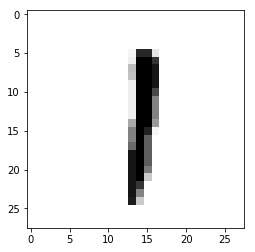

In [63]:
outlier = [x for x in part if part[x]==5][0]
print(labels[outlier])
print(np.argmax(layer_outs[0][:,perm[outlier]]))
print(np.argmax(Y_test,axis=1)[repr_indices[max_vals!=0]][outlier])
for i in range(9):
    print(np.argsort(np.abs(layer_outs[0]), axis=0)[-9:,:][i,:][perm][max_vals!=0][outlier])
print(np.argmax(Y_test,axis=1)[top9][0,:][perm][max_vals!=0][outlier])
# img = X_test[repr_indices[max_vals!=0][77]][0].copy()
# plt.imshow(img)
for i in range(9):
    idx = np.argsort(np.abs(layer_outs[0]), axis=0)[-9:,:][i,:][perm][max_vals!=0][outlier]
    plt.imshow(X_test[idx][0], cmap='binary')
    plt.show()

In [64]:
print(perm)
print(outlier)
orig_idx = np.argwhere(perm==outlier)[0][0]
print(orig_idx)
print(perm[outlier])
print(weights.shape)
print(weights[outlier,:])
print(np.array(m.layers[-3].get_weights()[0]).transpose()[perm[outlier],:])

[ 45  82  83 102  85 127  22  40  33 119  56  62  88  14  97 104  70  46
 121  74  93  71 114 101   6   2  10  39  51 116 106  57  69   8  12 126
  49  80  11  54  72  73 112 123  19  96  52 115  55  94  90  21  42  15
  48 107 100 108  79  25  63  60  13  31   1 117  18  26  16  24   5  34
 118 103  20 109  65  23  78 113  91  75  36  17  35  38 105  68   4  81
  99  41  28   7  44  47  76 122   3   9  92  66 111 124  32  89  50  84
   0  58  53  30  27  95 125 120  37  64  59  43  86  77 110  67  87  98
  29  61]
76
96
65
(128, 4608)
[ 0.03389207  0.06081374  0.10215569 ... -0.14875482 -0.12148552
 -0.13054612]
[ 0.03389207  0.06081374  0.10215569 ... -0.14875482 -0.12148552
 -0.13054612]


In [65]:
weights = model.get_weights()
# Remove the outlier
weights[-2][perm[outlier],:] = 0.0

config = model.get_config()
from keras.models import Sequential
model10 = Sequential.from_config(config)
model10.set_weights(weights)
model10.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [66]:
from model_generation import generate_data
X_train, X_test, Y_train, Y_test = generate_data(nums=nums)
score = model.evaluate(X_test[5000:], Y_test[5000:], verbose=0)
print(score)

[0.01642954600288649, 0.9964]


In [67]:
score = model10.evaluate(X_test[5000:], Y_test[5000:], verbose=0)
print(score)

[0.01634669058425079, 0.9964]
